# Continuation of Makemore - MLP
The last tutorial was based on the following paper by [Bengio, et all](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf) and the lovely YouTube series by Andrej Karpathy. This goes forward with more on the MLP thinking through batch normalization and optimiazaion. 

In the last we made a bigram model through counts and a simple 1 layer NN. This time we will be following this paper to make a version of an MLP. 

I will be building out a similar to [this tool](https://github.com/karpathy/makemore/tree/master) from scratch. Note that I will be following the tutorial doing it step by step not looking at the final repo. 

Over all I will work through these papers:
- Bigram (one character predicts the next one with a lookup table of counts)
- MLP, following [Bengio et al. 2003](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf)
- CNN, following [DeepMind WaveNet 2016](https://arxiv.org/abs/1609.03499) (in progress...)
- RNN, following [Mikolov et al. 2010](https://www.fit.vutbr.cz/research/groups/speech/publi/2010/mikolov_interspeech2010_IS100722.pdf)
- LSTM, following [Graves et al. 2014](https://arxiv.org/abs/1308.0850)
- GRU, following [Kyunghyun Cho et al. 2014](https://arxiv.org/abs/1409.1259)
- Transformer, following [Vaswani et al. 2017](https://arxiv.org/abs/1706.03762

In [1]:
import torch
import math
import numpy as np
import matplotlib.pyplot as plt
import random
import torch.nn.functional as F
%matplotlib inline

In [2]:
words = open("data/names.txt", "r").read().splitlines()
print(f'Total number of words: {len(words)}')
smallest = min(len(w) for w in words)
largest = max(len(w) for w in words)
print(f'Smallest Word is {smallest} char while the largest is {largest} char')

Total number of words: 32033
Smallest Word is 2 char while the largest is 15 char


In [81]:
# build the covabulary of chars and mappings 
chars = sorted(list(set(''.join(words))))
str_to_ind = {s:i + 1 for i,s in enumerate(chars)}
str_to_ind['.'] = 0
ind_to_str = {i:s for s,i in str_to_ind.items()}
print(ind_to_str)
vocab_size = len(ind_to_str)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [83]:
def build_dataset(words, block_size=3):
    X, Y = [], []
    for word in words:
        context = [0] * block_size # padded
        for ch in word + '.':
            ind = str_to_ind[ch]
            X.append(context)
            Y.append(ind)
            context = context[1:] + [ind] # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

block_size=3
X_train, Y_train = build_dataset(words[:n1], block_size=block_size)
X_dev, Y_dev = build_dataset(words[n1:n2], block_size=block_size)
X_test, Y_test = build_dataset(words[n2:], block_size=block_size)

torch.Size([182580, 3]) torch.Size([182580])
torch.Size([22767, 3]) torch.Size([22767])
torch.Size([22799, 3]) torch.Size([22799])


In [125]:
total_epochs = 0
lossi = []
n_emb_dim = 10
hidden_nodes = 200
input_size = n_emb_dim*block_size

g = torch.Generator().manual_seed(2147483647) # reproducibility 
C = torch.randn((vocab_size, n_emb_dim), generator=g)
gain = 5/3 
kaining_normal = gain / input_size**0.5
W1 = torch.randn((input_size, hidden_nodes),   generator=g) * kaining_normal             
W2 = torch.randn((hidden_nodes,vocab_size),    generator=g) * 0.01 # scale this down to match 
b2 = torch.randn(vocab_size,                   generator=g) * 0 # zero this out

bngain = torch.ones((1, hidden_nodes))
bnbias = torch.zeros((1, hidden_nodes))
bnmean_running = torch.zeros((1, hidden_nodes))
bnstd_running = torch.ones((1, hidden_nodes))

parameters = [C, W1, W2, b2, bngain, bnbias]

print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

12097


In [126]:
# nll of true standardized prob 
-torch.tensor(1/27.0).log()

tensor(3.2958)

In [127]:
epoch = 200000
learning_rate = 0.1
decay = 0.1
batch_size = 32
decay_threshold = 100000

for i in range(epoch):
    
    # minibatch contstruct, faster although not exact
    ix = torch.randint(0, X_train.shape[0], (batch_size, ), generator=g)
    Xb, Yb = X_train[ix], Y_train[ix]
    
    # forward
    emb = C[Xb]     
    emb_concat = emb.view(emb.shape[0],-1)
    hidden_pre_activation = emb_concat @ W1
    
    # batch normlaizaiton
    hidden_mean = hidden_pre_activation.mean(0, keepdim=True)
    hidden_std = hidden_pre_activation.std(0, keepdim=True)
    hidden_pre_activation = bngain * (hidden_pre_activation - hidden_mean) / hidden_std + bnbias
    
    
    # calculate the running bmean and bstd, slight smoothing
    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * hidden_mean
        bnstd_running = 0.999 * bnstd_running + 0.001 * hidden_std
    
    hidden = torch.tanh(hidden_pre_activation)      
    logits = hidden @ W2 + b2                            
    loss = F.cross_entropy(logits, Yb)

    # backward
    for p in parameters:
        p.grad = None # zero_grade
        
    loss.backward()
    # update
    for p in parameters:
        p.data += -learning_rate * p.grad
    
    if total_epochs > 0 and total_epochs%decay_threshold == 0:
        learning_rate *= decay
        
            
    if i % 10000 == 0 or i == epoch-1:
        print(f"epoch: {total_epochs:6} batch: {i:7}/{epoch:7} loss: {loss.item():5.3f}")

    # track stats
    lossi.append(loss.log10().item())
    total_epochs += 1
    

epoch:      0 batch:       0/ 200000 loss: 3.286
epoch:  10000 batch:   10000/ 200000 loss: 2.134
epoch:  20000 batch:   20000/ 200000 loss: 2.137
epoch:  30000 batch:   30000/ 200000 loss: 2.229
epoch:  40000 batch:   40000/ 200000 loss: 2.013
epoch:  50000 batch:   50000/ 200000 loss: 1.731
epoch:  60000 batch:   60000/ 200000 loss: 2.274
epoch:  70000 batch:   70000/ 200000 loss: 2.234
epoch:  80000 batch:   80000/ 200000 loss: 2.383
epoch:  90000 batch:   90000/ 200000 loss: 2.072
epoch: 100000 batch:  100000/ 200000 loss: 2.207
epoch: 110000 batch:  110000/ 200000 loss: 2.171
epoch: 120000 batch:  120000/ 200000 loss: 2.279
epoch: 130000 batch:  130000/ 200000 loss: 1.881
epoch: 140000 batch:  140000/ 200000 loss: 1.787
epoch: 150000 batch:  150000/ 200000 loss: 2.180
epoch: 160000 batch:  160000/ 200000 loss: 1.934
epoch: 170000 batch:  170000/ 200000 loss: 1.959
epoch: 180000 batch:  180000/ 200000 loss: 2.104
epoch: 190000 batch:  190000/ 200000 loss: 2.036
epoch: 199999 batch:

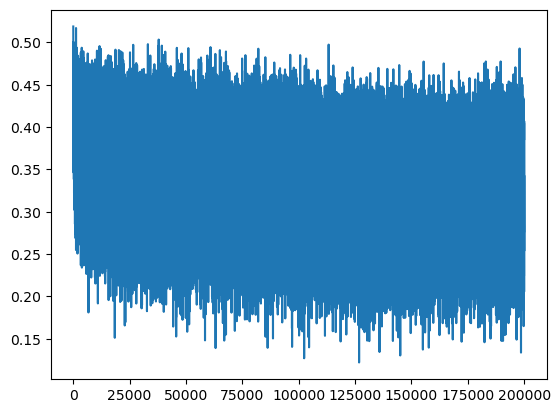

In [115]:
plt.plot(lossi)

In [129]:
@torch.no_grad()
def split_loss(split):
    x,y = {
        'train': (X_train, Y_train),
        'valid': (X_dev, Y_dev),
        'test': (X_test, Y_test),
    }[split]
    
    # Evaluate parameters
    emb = C[x]     
    emb_concat = emb.view(emb.shape[0],-1)
    
    # batch normlaizaiton
    hidden_pre_activation = emb_concat @ W1
    hidden_pre_activation = bngain * (hidden_pre_activation - bnmean_running) / bnstd_running + bnbias
    
    h = torch.tanh(hidden_pre_activation) 
    logits = h @ W2 + b2    
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())
    
split_loss('train')
split_loss('valid')

train 2.0657219886779785
valid 2.109694719314575


In [ ]:
g = torch.Generator().manual_seed(2147483647 + 10) # reproducibility 

for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]                       # Size([1, block_size, d])
        hidden = torch.tanh(emb.view(-1,input_size) @ W1 + b1) 
        logits = hidden @ W2 + b2             
        probs = F.softmax(logits, dim=1)
        index = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [index]
        out.append(index)
        if index == 0:
            break
    
    print(''.join(ind_to_str[i] for i in out))

### Notes

The following was run at just 1 step.

(array([2319.,  135.,  117.,   36.,   58.,   41.,   38.,   35.,   28.,
          23.,   17.,   18.,   15.,   19.,   14.,   14.,   18.,   19.,
          12.,   12.,   18.,   24.,   14.,   12.,   16.,   15.,    8.,
          21.,   21.,   24.,   21.,   16.,   10.,   19.,   30.,   28.,
          21.,   16.,   16.,   18.,   25.,   24.,   35.,   40.,   48.,
          47.,   53.,   92.,  149., 2531.]),
 array([-1.  , -0.96, -0.92, -0.88, -0.84, -0.8 , -0.76, -0.72, -0.68,
        -0.64, -0.6 , -0.56, -0.52, -0.48, -0.44, -0.4 , -0.36, -0.32,
        -0.28, -0.24, -0.2 , -0.16, -0.12, -0.08, -0.04,  0.  ,  0.04,
         0.08,  0.12,  0.16,  0.2 ,  0.24,  0.28,  0.32,  0.36,  0.4 ,
         0.44,  0.48,  0.52,  0.56,  0.6 ,  0.64,  0.68,  0.72,  0.76,
         0.8 ,  0.84,  0.88,  0.92,  0.96,  1.  ]),
 <BarContainer object of 50 artists>)

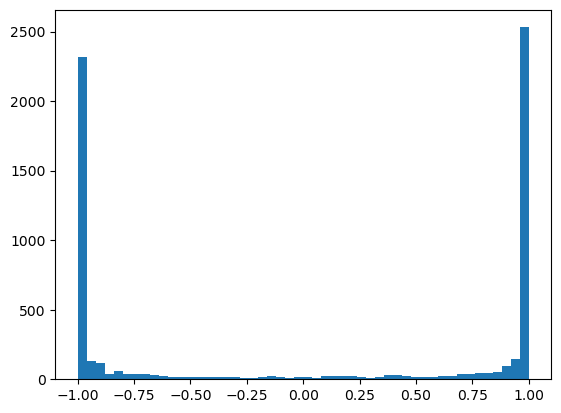

In [51]:
# This shows a super active tanh
plt.hist(hidden.view(-1).tolist(), 50)

This is really quite nerve wracking for how gradient decent works. As this is 1 or -1 it will take our gradient decent of tanh (grad += (1- t**2) * out.grad) thus this would vanish the gradient as it would be basically 0. Uh oh. 

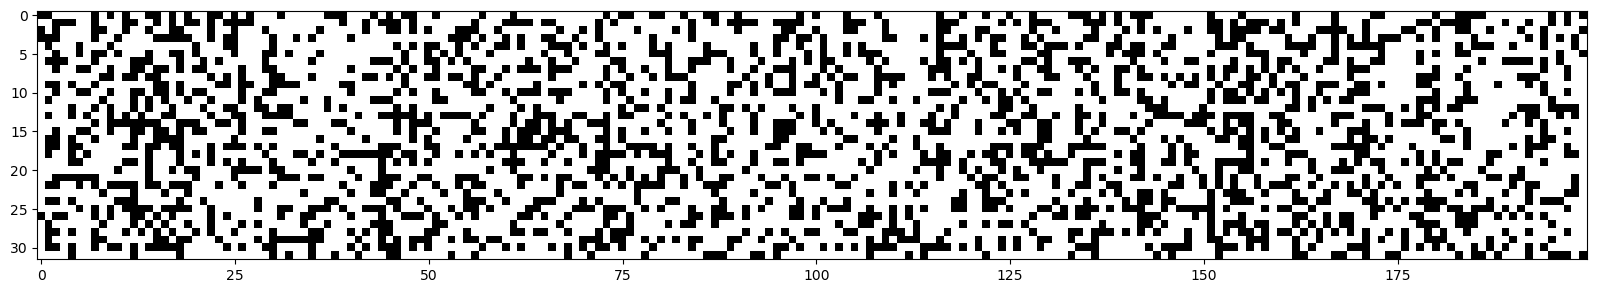

In [54]:
plt.figure(figsize=(20,10))
plt.imshow(hidden.abs() > 0.99, cmap='gray', interpolation='nearest')

In this if we saw a column all white it would be a completely dead neuron and it won't learn. Thankfully we can see we don't have that right now, but good to look at.

Note this will be the same to other activation functions such as sigmoid (another squishing), ReLU (flat area), etc. Watch out for any flat in the function.

This can also happen during optimization as well. 

Now let's fix this by changing the scale of W1 and b1. We can see it's mostly black much better!

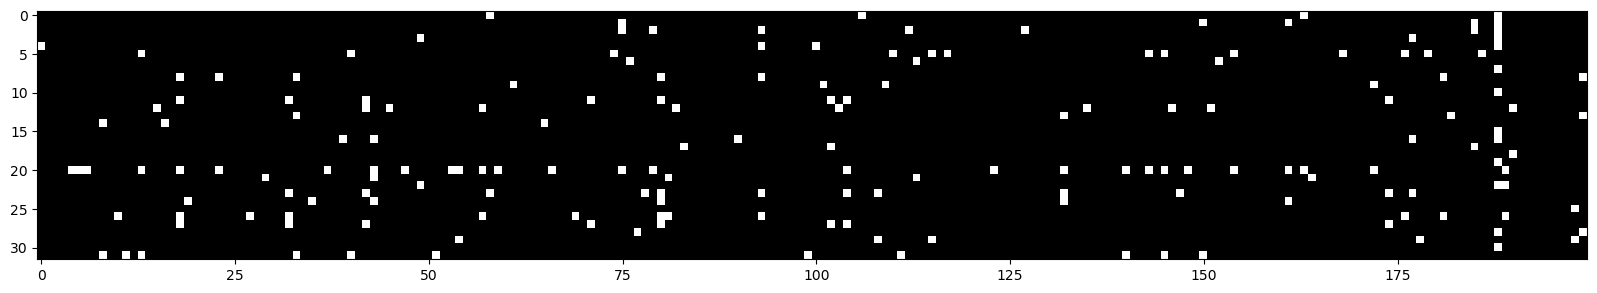

In [65]:
plt.figure(figsize=(20,10))
plt.imshow(hidden.abs() > 0.99, cmap='gray', interpolation='nearest')

Now how do we do the scales in a non magic number sort of way? Let's see what happens when you take two gauseans and multiple them

tensor(-0.0047) tensor(1.0035)
tensor(0.0055) tensor(3.2907)


(array([1.41803812e-05, 0.00000000e+00, 0.00000000e+00, 7.09019059e-06,
        7.09019059e-06, 2.12705718e-05, 5.67215247e-05, 9.21724776e-05,
        1.77254765e-04, 2.97788005e-04, 4.96313341e-04, 7.58650393e-04,
        1.22660297e-03, 1.99943375e-03, 3.37493072e-03, 5.36018408e-03,
        8.71384423e-03, 1.24503747e-02, 1.82856015e-02, 2.65456736e-02,
        3.78970687e-02, 5.09217488e-02, 6.76049672e-02, 8.42243740e-02,
        1.00730338e-01, 1.16704537e-01, 1.25893424e-01, 1.29169092e-01,
        1.24844076e-01, 1.12457513e-01, 9.67031094e-02, 7.81197199e-02,
        6.21597009e-02, 4.56608274e-02, 3.35720524e-02, 2.40215657e-02,
        1.60663719e-02, 1.16279126e-02, 7.22490421e-03, 4.99858436e-03,
        2.99206043e-03, 1.90017108e-03, 1.15570107e-03, 6.23936772e-04,
        3.47419339e-04, 2.41066480e-04, 1.41803812e-04, 7.79920965e-05,
        4.96313341e-05, 2.12705718e-05]),
 array([-19.2793026 , -18.57410294, -17.86890327, -17.16370361,
        -16.45850395, -15.7533

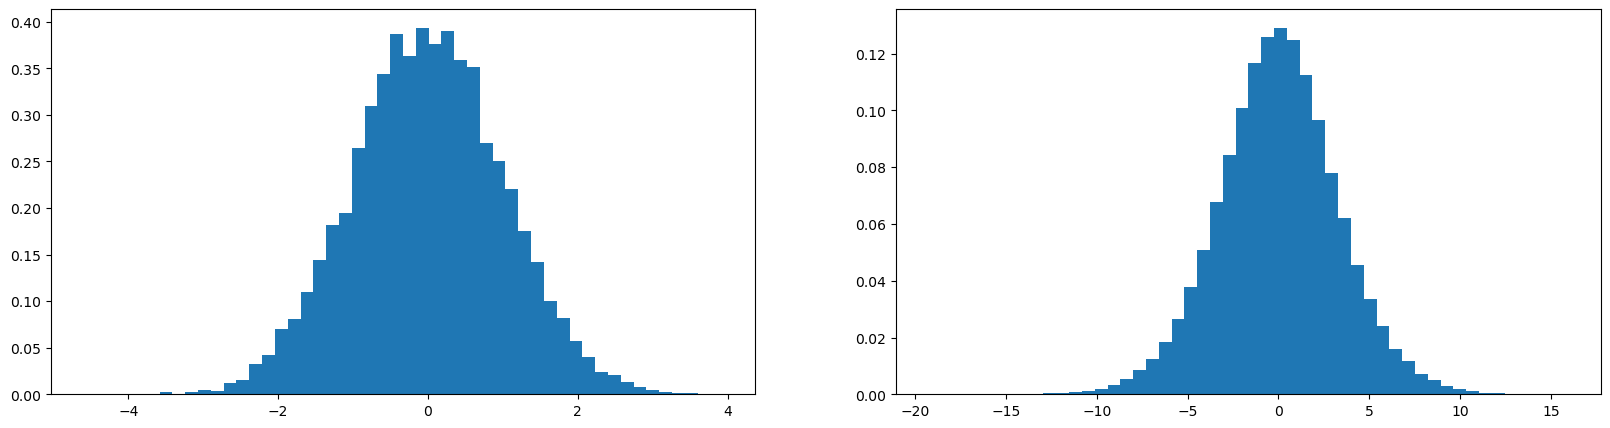

In [73]:
x = torch.randn(1000, 10)
w = torch.randn(10, 200)
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True)
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True)

tensor(0.0074) tensor(0.9931)
tensor(-0.0407) tensor(16.0435)


(array([2.53656796e-06, 5.07313592e-06, 2.53656796e-06, 2.53656796e-06,
        7.60970387e-06, 1.39511238e-05, 2.79022475e-05, 3.80485194e-05,
        6.59507669e-05, 1.14145558e-04, 1.88974313e-04, 2.91705315e-04,
        5.37752407e-04, 8.67506242e-04, 1.48642882e-03, 2.43130039e-03,
        3.82768105e-03, 5.45742596e-03, 8.27047983e-03, 1.15236282e-02,
        1.55973564e-02, 1.97294256e-02, 2.37980806e-02, 2.62572832e-02,
        2.68876204e-02, 2.48101712e-02, 2.17840456e-02, 1.75061238e-02,
        1.33626400e-02, 9.86090794e-03, 6.71302710e-03, 4.66474847e-03,
        2.86885836e-03, 1.89608455e-03, 1.12369961e-03, 6.86141633e-04,
        3.93168033e-04, 2.20681412e-04, 1.50925794e-04, 7.73653227e-05,
        4.69265072e-05, 2.79022475e-05, 1.39511238e-05, 6.34141990e-06,
        5.07313592e-06, 2.53656796e-06, 1.26828398e-06, 0.00000000e+00,
        0.00000000e+00, 1.26828398e-06]),
 array([-95.58573914, -91.64340439, -87.70106964, -83.75873489,
        -79.81640015, -75.8740

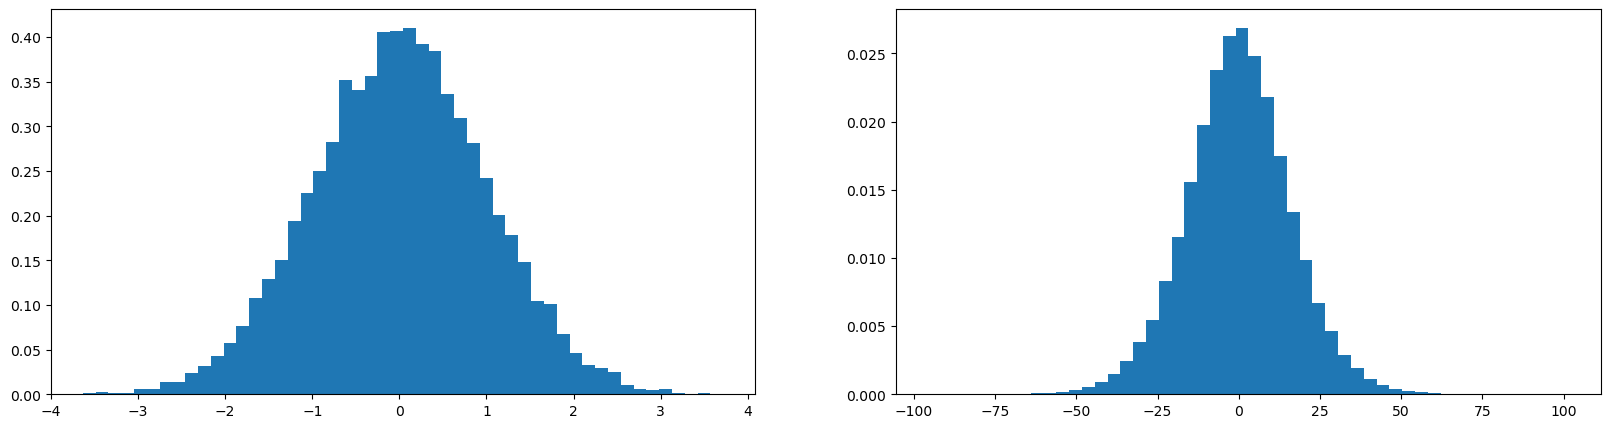

In [74]:
x = torch.randn(1000, 10)
w = torch.randn(10, 200) * 5
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True)
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True)

tensor(-0.0003) tensor(1.0024)
tensor(-0.0017) tensor(0.6493)


(array([3.20711893e-05, 1.28284757e-04, 3.20711893e-05, 2.56569514e-04,
        5.13139028e-04, 2.88640703e-04, 7.37637353e-04, 1.44320352e-03,
        2.40533920e-03, 3.88061390e-03, 7.66501424e-03, 1.05834925e-02,
        2.03331340e-02, 3.06921281e-02, 5.19873978e-02, 7.61370033e-02,
        1.15584566e-01, 1.75269049e-01, 2.45344598e-01, 3.34662860e-01,
        4.41459920e-01, 5.34049444e-01, 6.20609584e-01, 6.63841547e-01,
        6.55727536e-01, 5.92771791e-01, 5.02651749e-01, 3.95149123e-01,
        3.00410830e-01, 2.08847585e-01, 1.46308765e-01, 1.00446965e-01,
        6.59704363e-02, 4.17246172e-02, 2.61700904e-02, 1.65166625e-02,
        1.00703534e-02, 6.28595310e-03, 3.49575963e-03, 1.50734590e-03,
        8.65922110e-04, 6.09352596e-04, 2.88640703e-04, 2.56569514e-04,
        1.28284757e-04, 6.41423785e-05, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 3.20711893e-05]),
 array([-3.71211767, -3.5562145 , -3.40031134, -3.24440817, -3.088505  ,
        -2.93260183, 

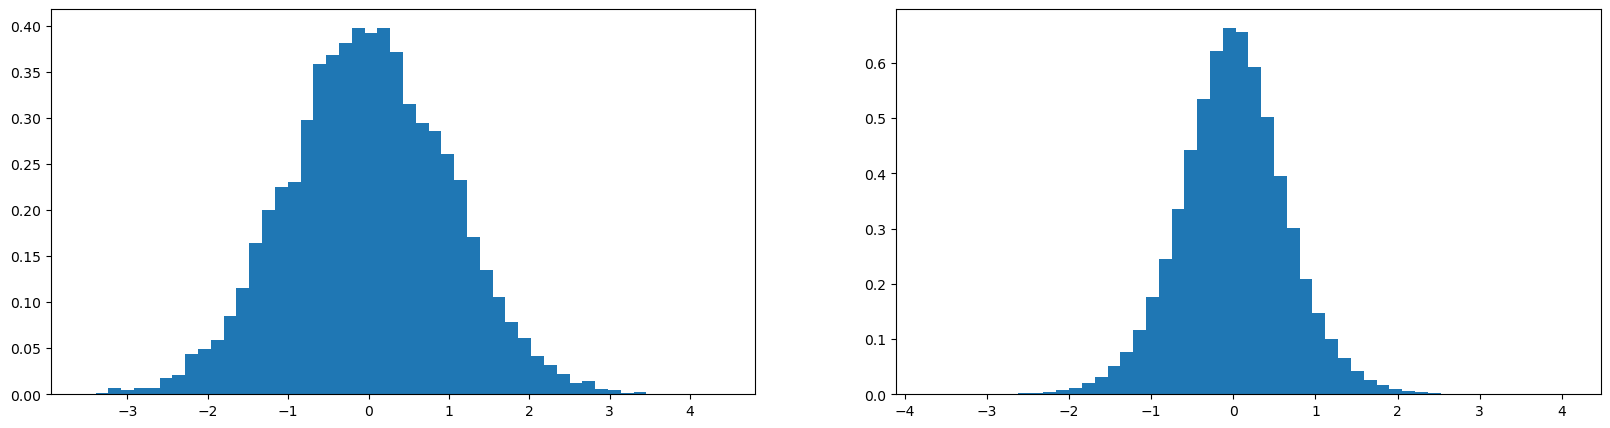

In [75]:
x = torch.randn(1000, 10)
w = torch.randn(10, 200) * .2
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True)
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True)

tensor(0.0023) tensor(0.9964)
tensor(-0.0008) tensor(0.9953)


(array([2.02031513e-05, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 4.04063026e-05, 2.02031513e-05, 0.00000000e+00,
        8.08126053e-05, 1.61625211e-04, 2.42437816e-04, 3.03047270e-04,
        1.01015757e-03, 1.57584580e-03, 2.88905064e-03, 4.72753741e-03,
        8.72776137e-03, 1.45664721e-02, 2.27285452e-02, 3.77596898e-02,
        5.94578743e-02, 8.96817887e-02, 1.33441814e-01, 1.91081405e-01,
        2.58297290e-01, 3.28887100e-01, 3.90789556e-01, 4.18568889e-01,
        4.22750941e-01, 3.94325108e-01, 3.45292059e-01, 2.75530578e-01,
        2.07425755e-01, 1.47543614e-01, 1.02632009e-01, 6.71552750e-02,
        4.35984006e-02, 2.84460371e-02, 1.62837400e-02, 1.04652324e-02,
        6.40439897e-03, 3.83859875e-03, 1.47483005e-03, 1.11117332e-03,
        7.47516599e-04, 3.23250421e-04, 1.21218908e-04, 4.04063026e-05,
        2.02031513e-05, 4.04063026e-05]),
 array([-6.9659853 , -6.71849916, -6.47101301, -6.22352687, -5.97604073,
        -5.72855458, 

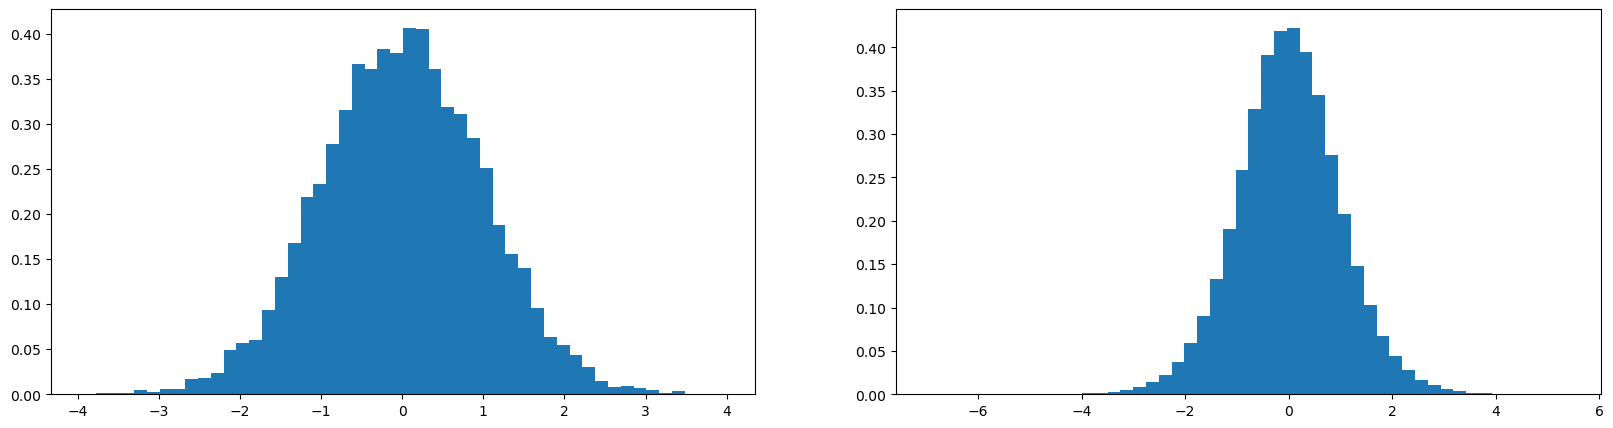

In [76]:
x = torch.randn(1000, 10)
w = torch.randn(10, 200) / 10**0.5
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True)
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True)

You can use init help from torch with e recommended gains and nonlinearity functions. This was really important to understand as they were finicky and important. Since then we usually get to use neat tools. 

In real practice a good basses is normalizing the weight by the square root of the fan_n (roughly what we did above). We can be more accurate by kaining_normal by set the std = gain/square root(fan_n) 

In [98]:
gain = 5/3 
kaining_normal = gain / input_size**0.5
W1 = torch.randn((input_size, hidden_nodes),   generator=g) * kaining_normal

Now let's move on to bringing in batch_normalization. The big idea here is that if we are wanting our init weidghts to be guassian with std=1 then why not just normalize them? This is easily differentiable. 

In [108]:
hidden_pre_activation.mean(0, keepdim=True).shape

torch.Size([1, 200])

In [111]:
hidden_pre_activation.std(0, keepdim=True).shape

torch.Size([1, 200])

Now we want this normalized at init we also really want it to be able to move around as it trains. Called scale and shift. We create the bngain and bnbias where gain is set to 1 and bias to 0 at the start. This keeps it nicely guassian, but as we train these to will be part of the grad and it will help shift it.

```hidden_pre_activation = bngain * (hidden_pre_activation - hidden_mean) / hidden_std + bnbias``` 

Our case won't show a big change in loss as we were already able to make this better with the manual kaining_normal. But htis is important as it gets bigger.

Batch norm are put in throughout the neural network and allows us to not be as careful in the init. There is a cost though - now our batches are tied together mathmatically. This can lead to a lot of bugs. It's not good, but it has some interesting side effects. It causes padding out and adding in jitter in the logits. This actually ahs a nice side effect by making it a regularizer that helps models not overfit. 

There are now also different normalizers that don't tie these but they don't regularize. 

With that we can now look at this. b1 gets subtracted out so let's get rid of the bias it's not helpful. 

This batch normalization get sprinkled throughout an NN typically after layers such as linear and convolutional. 


# Loss Log


after softmax and sautruated tanh fix
- train 2.0343804359436035
- valid 2.102403163909912

after having using kaining_normal
- train 2.0377557277679443
- valid 2.1032512187957764

adding batch_normalization
- train 2.065702438354492
- valid 2.1107828617095947

getting the bnmean_running and bnstd_running to be able to test on 1 (removed b1)
- train 2.0657219886779785
- valid 2.109694719314575

